In [ ]:
'''
Signals Project, Deliverable #2
 
BME 252 - Linear Systems and Signals
 
Sunny Willert 20619549
Vincent Shadbolt 20617236
Samantha Feng 20604727
 
June 22, 2017
 
'''

In [12]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate as itg
from scipy import signal
from matplotlib import pyplot as plt

In [35]:
# import data, remove unnecessary cells
# data = pd.read_csv('C:\Users\Sunny\Documents\signals_project\sunny_1.csv', header=0)
data = pd.read_csv('C:\\Users\\Sam\\Documents\\Signals\\sunny_1.csv', header=0)
del data['Unnamed: 7']

# instantiate new unit vector df, pitch/roll df, and global variable df
unit_vec = pd.DataFrame(columns=['time','mag_a', 'ax_u','ay_u','az_u'])
pitch_roll = pd.DataFrame(columns=['time', 'pitch','roll','pitch_corr','roll_corr'])
global_vals = pd.DataFrame(columns=['time','ax','ay','az','wx','wy','wz'])

# create integral dataframes
int_1 = pd.DataFrame(columns=['time','ax_1','ay_1','az_1','wx_1','wy_1','wz_1'])
int_2 = pd.DataFrame(columns=['time','ax_2','ay_2','az_2'])

# create dataframes for average and maximum values
avg = pd.DataFrame(columns=['a','w','a_1','w_1','a_2','ax','ay','az','wx','wy','wz','ax_1','ay_1','az_1','wx_1','wy_1','wz_1'], 
                      index=['data'])
maxs = pd.DataFrame(columns=['a','w','a_1','w_1','a_2','ax','ay','az','wx','wy','wz','ax_1','ay_1','az_1','wx_1','wy_1','wz_1'], 
                      index=['data'])
plot_maxs = pd.DataFrame(columns=['data', 'time'], 
                      index=['a','w','ax','ay','az','wx','wy','wz'])

In [36]:
# integrate linear acceleration signal for linear velocity signal
# integrate resultant linear velocity signal for linear distance
# integrate angular velocity signal for angle

for _dir in ['x', 'y', 'z']:
    for _type in ['a', 'w']:
        int_1['{}{}_1'.format(_type, _dir)] = itg.cumtrapz(data['{}{}'.format(_type, _dir)], data['time'])
        int_1['time'] = data['time']
for _dir in ['x', 'y', 'z']:
    int_2['a{}_2'.format(_dir)] = itg.cumtrapz(int_1['a{}_1'.format(_dir)], int_1['time'])
    int_2['time'] = int_1['time']

In [51]:
# calculate magnitude of acceleration to determine unit vector for acceleration in each direction
unit_vec['time'] = data['time']
unit_vec['mag_a'] = np.sqrt(data['ax']**2 + data['ay']**2 + data['az']**2)

# determine unit vectors for acceleration for pitch and roll calculations
for _dir in ['x', 'y', 'z']:
    unit_vec['a{}_u'.format(_dir)] = data['a{}'.format(_dir)] / unit_vec['mag_a']

# calculating pitch and roll only for time in which subject is standing
pitch_roll['time'] = data['time']
pitch_roll = pitch_roll.drop(pitch_roll[pitch_roll.time > 5].index)

for _type in ['pitch', 'roll']:
    if _type == 'pitch':
        pitch_roll[_type] = -np.arctan2(unit_vec['az_u'], np.sqrt(unit_vec['ax_u']**2 + unit_vec['ay_u']**2))*(180/np.pi)
    elif _type == 'roll':
        pitch_roll[_type] = -np.arctan2(-unit_vec['ax_u'], unit_vec['ay_u'])*(180/np.pi)

for _type in ['pitch_corr','roll_corr']:
    if _type == 'pitch_corr':
        pitch_roll[_type] = 0.98*int_1['wx_1']+0.02*pitch_roll['pitch']
    elif _type == 'roll_corr':
        pitch_roll[_type] = 0.98*int_1['wz_1']+0.02*pitch_roll['roll']
        
# determining average pitch and roll when still
pitch_avg = np.mean(pitch_roll['pitch_corr'])
roll_avg = np.mean(pitch_roll['roll_corr'])
print (pitch_avg)
print (roll_avg)

0.1733622845126608
0.4734428779501748


In [76]:
# filter noise in gyroscope data by removing on constant bias
cb = pd.DataFrame(columns=['wx_cb','wy_cb','wz_cb'])
filtered = pd.DataFrame(columns=['time','wx_f','wy_f','wz_f'])

# determine average of gyroscope data in each direction when no movement occurs - calculates offset
for _dir in ['x', 'y', 'z']:
    cb.loc['data', 'w{}_cb'.format(_dir)] = np.mean(data['w{}'.format(_dir)][:600])

# subtract offset from 
for _dir in ['x', 'y', 'z']:
    filtered['w{}_f'.format(_dir)] = data['w{}'.format(_dir)] - cb.loc['data']['w{}_cb'.format(_dir)]
    filtered['time'] = data['time']
    
# integrate filtered gyroscope data for filtered angle
filtered_1 = pd.DataFrame(columns=['time', 'wx_f1', 'wy_f1', 'wz_f1'])
for _dir in ['x', 'y', 'z']:
    filtered_1['w{}_f1'.format(_dir)] = itg.cumtrapz(filtered['w{}_f'.format(_dir)], filtered['time'])
    filtered_1['time'] = data['time']

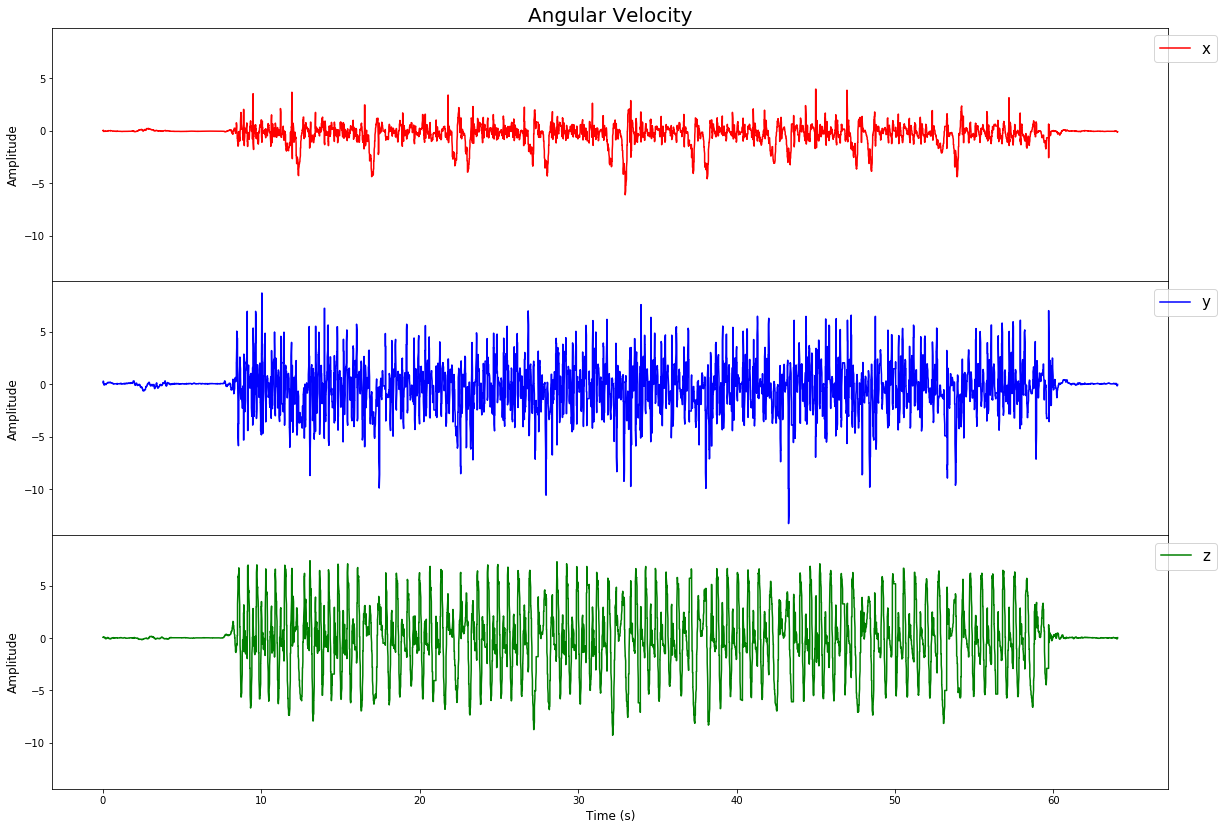

In [126]:
### ANGULAR VELOCItY ###

# create 3 subfigures for angular velocity: angular velocity about the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))
    
# Format labels and title for graphs
ax1.set_title('Angular Velocity', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

ax1.plot(filtered['time'], filtered['wx_f'], 'r-', label='x')
ax2.plot(filtered['time'], filtered['wy_f'], 'b-', label='y')
ax3.plot(filtered['time'], filtered['wz_f'], 'g-', label='z')

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
ax1.set_title('Angular Velocity', fontsize=20)
plt.show()

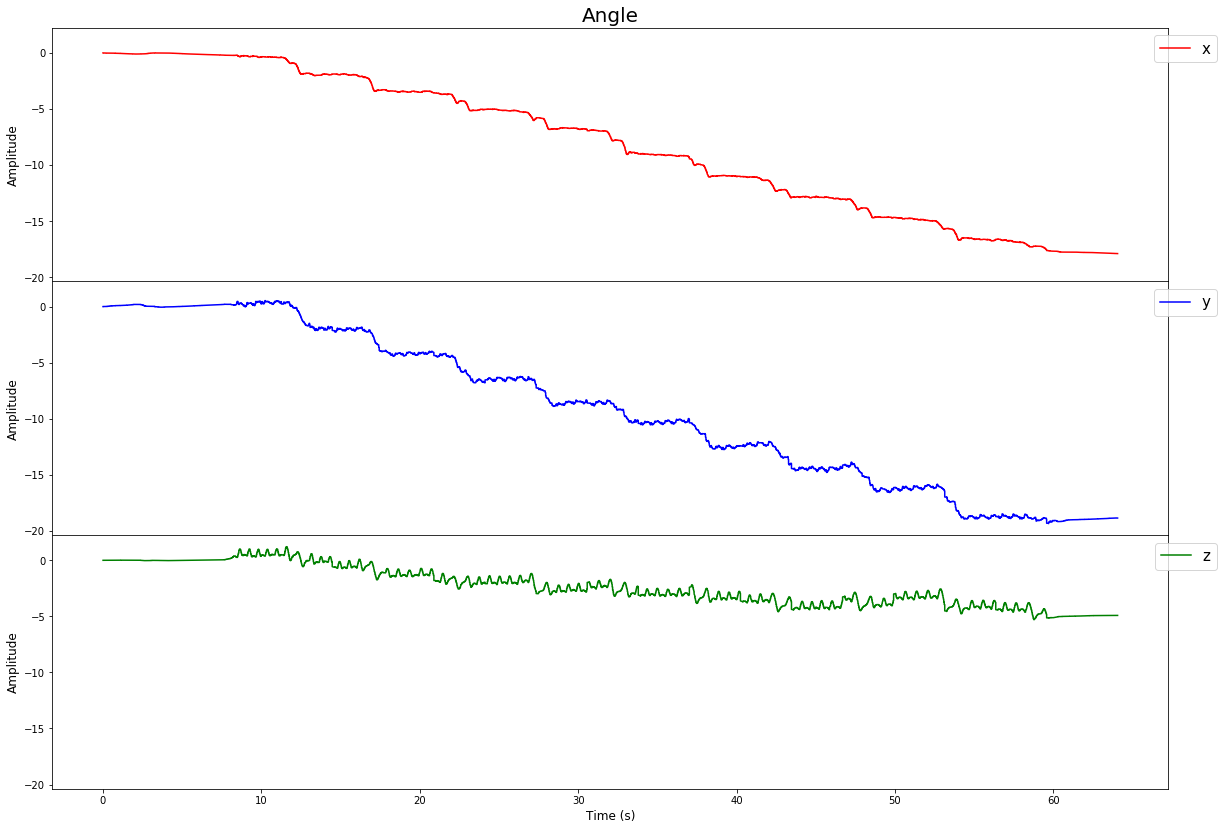

In [140]:
### ANGLE ###

# create 3 subfigures for angular velocity: angular velocity about the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))
    
# Format labels and title for graphs
ax1.set_title('Angle', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

ax1.plot(filtered_1['time'], filtered_1['wx_f1'], 'r-', label='x')
ax2.plot(filtered_1['time'], filtered_1['wy_f1'], 'b-', label='y')
ax3.plot(filtered_1['time'], filtered_1['wz_f1'], 'g-', label='z')

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
ax1.set_title('Angle', fontsize=20)
plt.show()